# 1D Heat Equation Using Physics Informed Neural Networks & DeepXDE Library

The equation governing the heat conduction in a one-dimensional rod without any internal heat generation and steady state is given by:

$$ \frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} $$

Where:
- $T$ is the temperature of the rod.
- $t$ is time.
- $x$ is the spatial coordinate along the length of the rod.
- $\alpha$ is the thermal diffusivity of the material.

In [2]:
import deepxde as dde
from deepxde.backend import torch
import numpy as np
from matplotlib import pyplot as plt

No backend selected.
Finding available backend...


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Found pytorch
Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [3]:
# Constants:
alpha = 0.4 # m2/s
L = 1 # meter
n = 1 # s

In [4]:
# Define the spatial and time domain:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, n)
# Combine two domains:
geomtime = dde.geometry.GeometryXTime(geometry = geom, timedomain = timedomain)

In [5]:
# Initial condition:
# Temperature distribution at t = 0 is sinusoidal
# on_initial: Apply it only at time t = 0
ic = dde.icbc.IC(geomtime, lambda x: np.sin(n* np.pi * x[:,0:1]/L), lambda _, on_initial: on_initial)

In [6]:
def double_first_column(input_array):
    """Doubles the first column of the input array."""
    return 2 * input_array[:, 0:1]

# Boundary condition
bc = dde.icbc.DirichletBC(geomtime, double_first_column, lambda _, on_boundary: on_boundary)

In [7]:
def pde(comp,T):
    """Defines the PDE in terms of its derivatives."""
    dT_t = dde.grad.jacobian(T, comp, i = 0,j = 1)
    dT_xx = dde.grad.hessian(T, comp, i = 0,j = 0)
    return dT_t - alpha * dT_xx

In [8]:
# Collect PDE, boundary, and initial conditions:
data = dde.data.TimePDE(geomtime,
                       pde,
                       [bc, ic],
                       num_domain = 2540,
                       num_boundary = 80,
                       num_initial = 160,
                       num_test = 2540,
                       )

In [9]:
# Neural network architecture:
net = dde.nn.FNN([2] + [20]*3+ [1], "tanh", "Glorot normal")

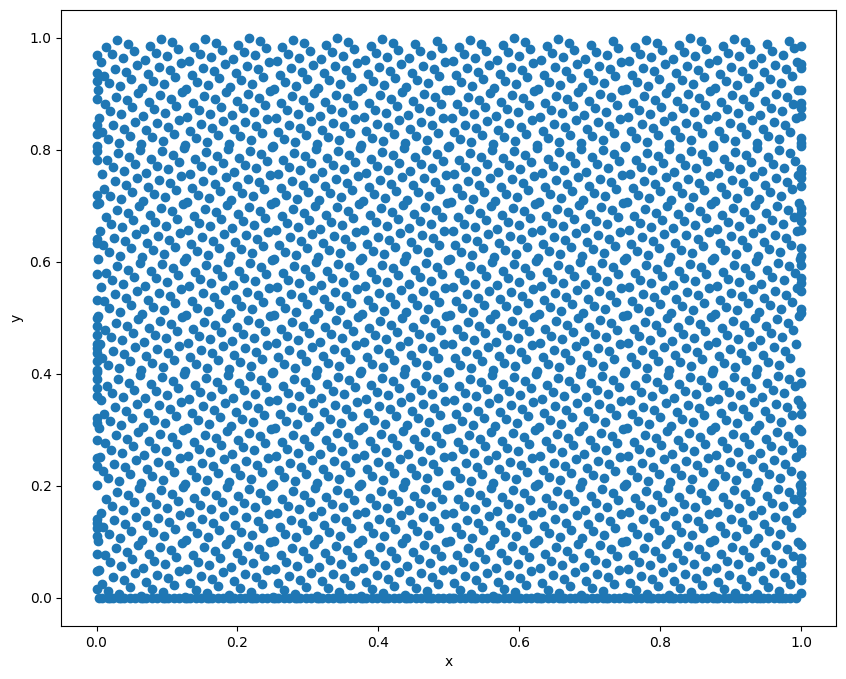

In [10]:
# Visualizing the data points
plt.figure(figsize = (10, 8))
plt.scatter(data.train_x_all[:, 0],data.train_x_all[:, 1])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [11]:
# Model setup:
model = dde.Model(data, net)
model.compile("adam", lr = 1e-3)

Compiling model...
'compile' took 4.430634 s



In [12]:
# Training using Adam for 15000 iterations
losshistory, train_state = model.train(iterations = 15000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.72e-01, 1.77e+00, 4.84e-01]    [1.70e-01, 1.77e+00, 4.84e-01]    []  
1000      [9.98e-03, 6.60e-02, 1.60e-01]    [6.88e-03, 6.60e-02, 1.60e-01]    []  
2000      [6.57e-03, 3.52e-02, 2.74e-02]    [4.60e-03, 3.52e-02, 2.74e-02]    []  
3000      [3.60e-03, 2.06e-02, 1.42e-02]    [2.92e-03, 2.06e-02, 1.42e-02]    []  
4000      [2.30e-03, 1.63e-02, 1.07e-02]    [1.75e-03, 1.63e-02, 1.07e-02]    []  
5000      [1.69e-03, 1.42e-02, 9.01e-03]    [1.32e-03, 1.42e-02, 9.01e-03]    []  


In [ ]:
# Training using Limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000494 s

Training model...

Step      Train loss                        Test loss                         Test metric
15000     [1.84e-03, 1.06e-02, 7.10e-03]    [7.71e-04, 1.06e-02, 7.10e-03]    []  
16000     [8.29e-04, 7.29e-04, 6.59e-04]    [5.91e-04, 7.29e-04, 6.59e-04]    []  
17000     [4.01e-04, 1.64e-04, 1.46e-04]    [2.92e-04, 1.64e-04, 1.46e-04]    []  
18000     [1.92e-04, 8.04e-05, 1.11e-04]    [1.55e-04, 8.04e-05, 1.11e-04]    []  
19000     [1.69e-04, 4.03e-05, 5.67e-05]    [1.32e-04, 4.03e-05, 5.67e-05]    []  
20000     [1.37e-04, 3.98e-05, 5.02e-05]    [9.69e-05, 3.98e-05, 5.02e-05]    []  
21000     [1.20e-04, 3.46e-05, 3.43e-05]    [9.63e-05, 3.46e-05, 3.43e-05]    []  
22000     [1.02e-04, 2.76e-05, 2.85e-05]    [8.47e-05, 2.76e-05, 2.85e-05]    []  
23000     [9.09e-05, 2.66e-05, 2.78e-05]    [7.29e-05, 2.66e-05, 2.78e-05]    []  
24000     [7.75e-05, 2.92e-05, 2.53e-05]    [6.13e-05, 2.92e-05, 2.53e-05]    []  
25000     [6.50

Saving loss history to c:\Users\nmert\OneDrive\Data Science\Data Science Journal\datascience_journal\physics_informed_neural_networks\loss.dat ...
Saving training data to c:\Users\nmert\OneDrive\Data Science\Data Science Journal\datascience_journal\physics_informed_neural_networks\train.dat ...
Saving test data to c:\Users\nmert\OneDrive\Data Science\Data Science Journal\datascience_journal\physics_informed_neural_networks\test.dat ...


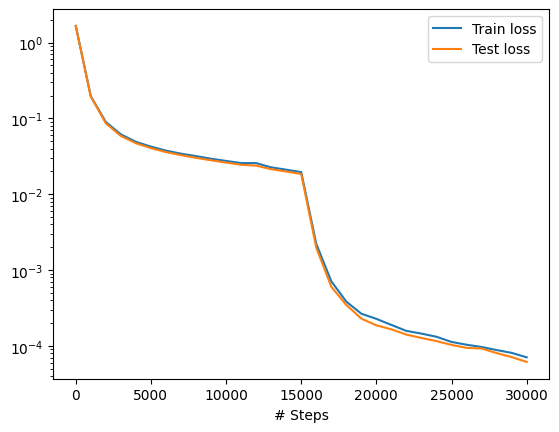

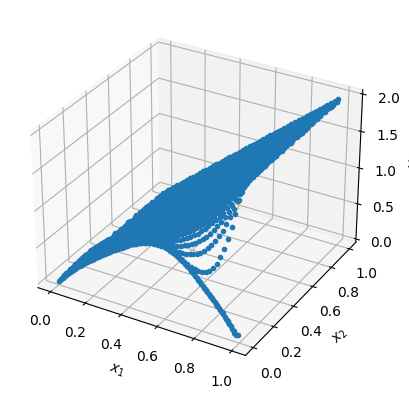

In [ ]:
# Save and plot the training progress:
dde.saveplot(losshistory,train_state, issave = True, isplot = True)